In [1]:
import pandas as pd
import os
import numpy as np
import geocoder
# import requests
import geopandas as gpd
%matplotlib inline
from matplotlib import pyplot as plt
import contextily as ctx
from geopandas import GeoDataFrame as gdf

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

In [38]:
df= pd.read_csv('data/buffers/corte_caba.csv')

In [11]:
df.to_csv('data/buffers/corte_caba.csv', index= False)

In [16]:
df.to_csv('data/buffers/corte_caba.csv', index = False)

In [39]:
df = df[['address', 'lat', 'lng']]

In [40]:
# df.insert(0, 'ID', df.index + 1)

df.head()

,address,lat,lng
0,"Bartolomé Mitre 1950, Balvanera, Ciudad de Buenos Aires, C1039, Ciudad Autónoma de Buenos Aires",-34.608180,-58.394240
1,"Ayacucho 170, Balvanera, Ciudad de Buenos Aires, C1025, Ciudad Autónoma de Buenos Aires",-34.607445,-58.395067
2,"Presidente José E. Uriburu 4, Balvanera, Ciudad de Buenos Aires, C1027, Ciudad Autónoma de Buenos Aires",-34.609555,-58.397668
3,"Viamonte 2932, Balvanera, Ciudad de Buenos Aires, C1213, Ciudad Autónoma de Buenos Aires",-34.600720,-58.407080
4,"Pasteur 434, Balvanera, Ciudad de Buenos Aires, C1028, Ciudad Autónoma de Buenos Aires",-34.604090,-58.399550


In [41]:
df.insert(0, 'ID', df.index + 1)
df0 = df.loc[0:600]
df1 = df.loc[601:]

In [42]:
del df

In [43]:
gdf0 = gpd.GeoDataFrame(df0, geometry=gpd.points_from_xy(df0.lng, df0.lat))
gdf1 = gpd.GeoDataFrame(df1, geometry=gpd.points_from_xy(df1.lng, df1.lat))

#Seteamos el CRS inicial (es lat lon) y luego lo convertimos al 5343, recomendado para Argentina. 
#Usa metros como unidad de medida

gdf0.crs = {"init": "EPSG:4326"}
gdf1.crs = {"init": "EPSG:4326"}
gdf0 = gdf0.to_crs(epsg = 5343)
gdf1 = gdf1.to_crs(epsg = 5343)

/home/mato/.local/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [44]:
gdf0 = gdf0[['address', 'ID','geometry']]

In [45]:
provincias = gpd.read_file('/home/mato/Documentos/Datos/OSDEPYM/mapas/Poligonos/provincia.json')
provincias = provincias.loc[(provincias['gid']==1)]
provincias.crs = {"init": "EPSG:4326"}
provincias = provincias.to_crs(epsg = 5343)

/home/mato/.local/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


Agregamos un buffer en el campo 'buffer'

In [58]:
gdf0['buffer']= gdf0.buffer(1000)

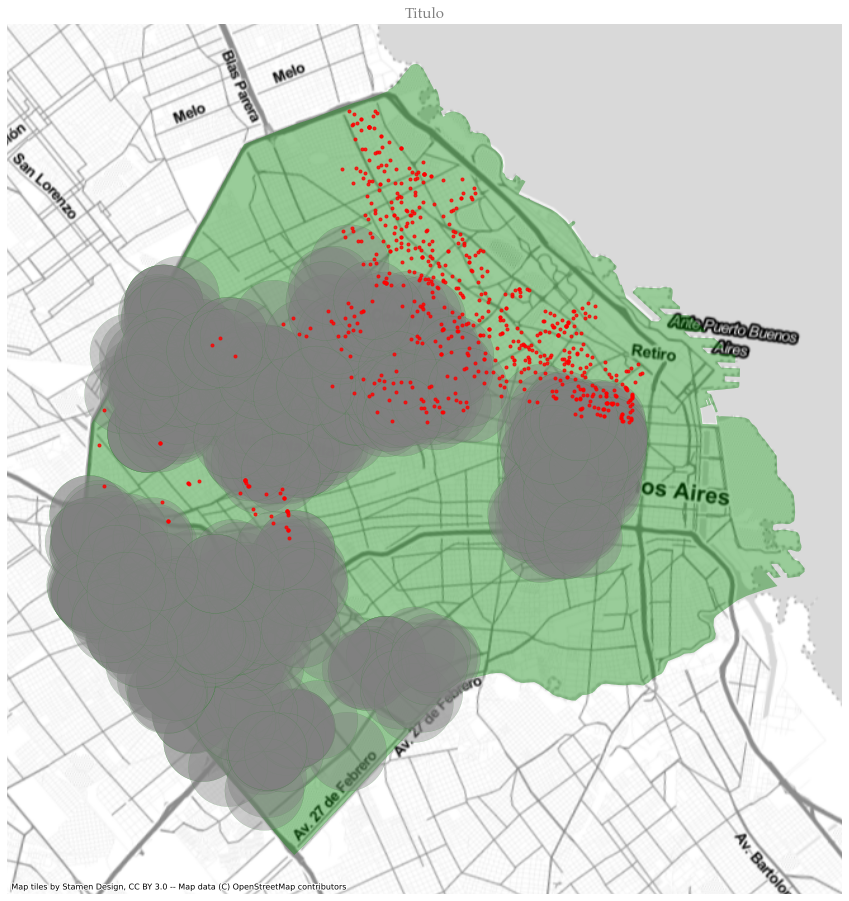

In [59]:
fig, ax = plt.subplots(figsize=(16,16))

provincias.plot(ax=ax, color='green', edgecolor='green', linewidth=0.2, alpha=0.4)
gdf0['buffer'].plot(ax=ax, color='grey', edgecolor='green', linewidth=0.2, alpha=0.4)
gdf1.plot(ax=ax, color = 'red', marker = '.', alpha=0.8)
ctx.add_basemap(ax, crs='epsg:5343', source=ctx.providers.Stamen.TonerLite)

plt.title('Titulo', fontsize=15, fontname='Palatino Linotype', color='grey')
ax.axis('off') 
plt.show()


# Cálculo de los puntos que caen en cada _buffer_

In [60]:
from shapely.geometry import Point, Polygon

Es una doble iteración. Por cada buffer, iteramos todos los puntos para ver cual queda adentro (within)
Y finalmente metemos el ID del buffer (id_b) y el ID del punto (id_punto) dentro de un dataframe (DF)

In [61]:
my_df = []
for id_b,b in zip(gdf0['ID'], gdf0['buffer']):
    for id_punto,punto in zip(gdf1['ID'], gdf1['geometry']):
        if punto.within(b):
            my_df.append([id_b, id_punto])
df = pd.DataFrame(my_df)
df.rename(columns = {0: 'id_buffer', 
                     1: 'id_punto'}, 
                     inplace = True)    
        

In [62]:
df

,id_buffer,id_punto
0,2,756
1,2,763
2,2,771
3,4,697
4,4,702
...,...,...
4571,601,676
4572,601,679
4573,601,680
4574,601,685


Agrupamos la cantidad de puntos por buffer, para graficarlo y ver si da como corresponde (x buffer con y puntos)

In [63]:
df.groupby('id_buffer').count().sort_values('id_punto', ascending = False)

,id_punto
id_buffer,
158,78
92,73
84,71
91,65
134,59
...,...
285,1
367,1
371,1


Filtramos el buffer 158, que debería incluir 77 puntos.

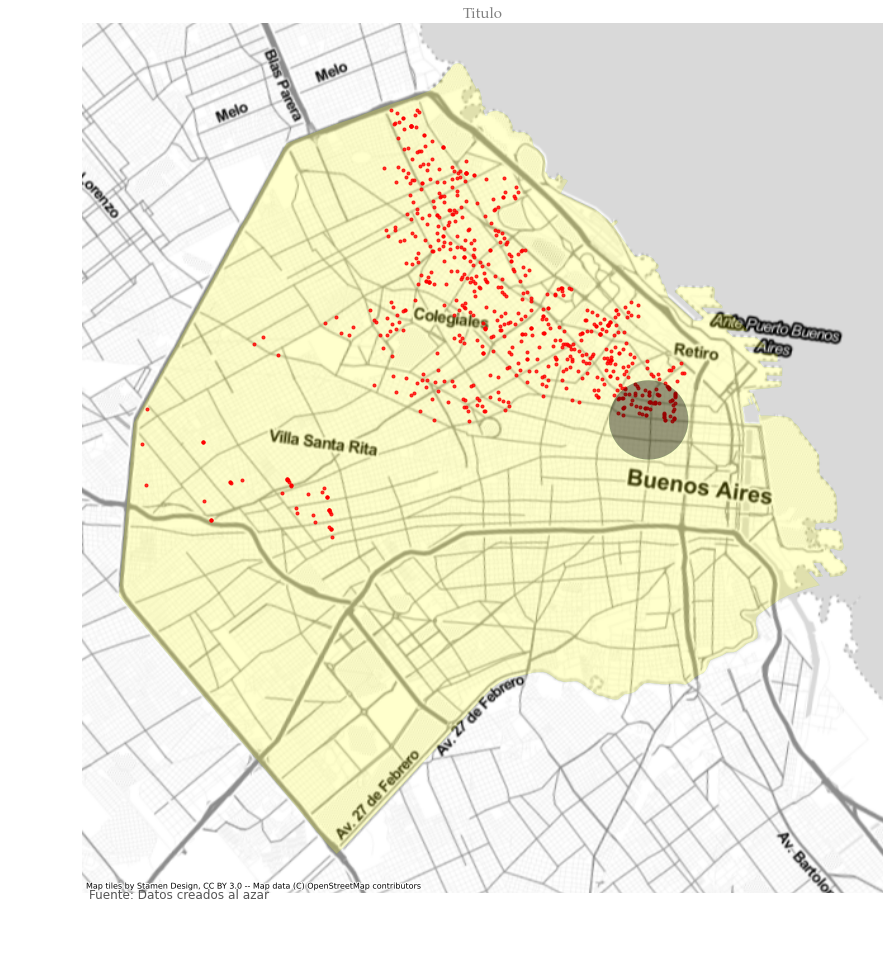

In [55]:
fig, ax = plt.subplots(figsize=(16,16)) # 1
a = gdf0.loc[(gdf0['ID']==158)]

provincias.plot(ax=ax, color='yellow', edgecolor='green', linewidth=0.2, alpha=0.2) # 2
# gdf0['buffer'].plot(ax=ax, color='grey', edgecolor='green', linewidth=0.2, alpha=0.4) # 2
gdf1.plot(ax=ax, color = 'red', marker = '.', alpha=0.8)
ctx.add_basemap(ax=ax, crs='epsg:5343', source=ctx.providers.Stamen.TonerLite, zoom=12)
a['buffer'].plot(ax=ax, color='black', edgecolor='green', linewidth=0.2, alpha=0.4) # 2



ylim = (-58.544584,  -58.322818)
xlim = (-34.715167,  -34.528056)

# ax.set_xlim(xlim)
# ax.set_ylim(ylim)

plt.title('Titulo', fontsize=15, fontname='Palatino Linotype', color='grey') # 3
ax.annotate('Fuente: Datos creados al azar',xy=(0.1, .08),  xycoords='figure fraction', horizontalalignment='left', verticalalignment='top', fontsize=12, color='#555555')
ax.axis('off') # 4
# plt.axis('equal') # 5
plt.show() # 6

# ISOCRONAS

In [64]:
# 1 - Create a graph
G = create_graph(loc= "Stockholm, Sweden", dist= 7000, transport_mode= "walk")
# 2 - Create nodes geodataframe from Graph network (G)
gdf_nodes = ox.graph_to_gdfs(G, edges=False)
# 3 - Specify where you want to start and get nearest nodes. 
point_of_interest = ox.get_nearest_node(G, point=(59.325273, 18.070998))
# 4 - Project a graph from lat-long to the UTM zone appropriate for its geographic location.
G = ox.project_graph(G)

NameError: name 'create_graph' is not defined